## Physics-Informed Neural Networks (PINNs) Practical Exercise
### Solving the 1D Heat Equation using PINNs

### 1: Import Libraries and Set Device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### 2: Define Problem Parameters and Initial Conditions

In [2]:
alpha = 0.01       # original thermal diffusivity [m^2/s]
L     = 1.0        # domain length [m]
T_max = 1000.0     # max time [s]
U_max = 100.0      # max temperature [°C]

system_params = {
    'alpha': alpha,
    'L': L,
    'T_max': T_max,
    'U_max': U_max
}
# Initial temperature distribution function to create a Gaussian-shaped distribution
def initial_condition_temp(x_values, system_params):
    # Parameters for Gaussian peak
    L = system_params['L']
    U_max = system_params['U_max']
    center = L / 2
    width = 0.03  # adjust this to make the peak narrower or wider
    peak_temperature = U_max  # adjust peak temperature as desired

    # Create Gaussian distribution with peak at center and width 
    t_initial = peak_temperature * torch.exp(-((x_values - center)**2) / (2 * width**2)) 
    return t_initial

#### Generate Training Data

In [3]:
def generate_training_data(system_params, n_domain, n_boundary):
    # Domain points for physics loss calculation
    L = system_params['L']
    T_max = system_params['T_max']
    U_max = system_params['U_max']
    
    x_domain = torch.rand(n_domain, 1, requires_grad=True) * L  # Random spatial points within [0, L]
    t_domain = torch.rand(n_domain,1,requires_grad=True) * T_max

    x_init = torch.rand(n_boundary, 1, requires_grad=True) * L # Random spatial points within [0, L]
    t_init = torch.zeros_like(x_init) # Set time points to 0
    u_init = initial_condition_temp(x_init, system_params) # Initial temperature distribution
    
    x_boundary = torch.cat((torch.zeros(n_boundary//2, 1), L * torch.ones(n_boundary//2, 1)), dim=0) # Set boundary points to 0 and L
    t_boundary = torch.rand(n_boundary, 1) * T_max # Random time points within [0, T_max]
    u_boundary = torch.zeros_like(x_boundary) # Set boundary temperature to 0

    # Normalize the data to the range of 0 to 1 for better training
    x_domain = x_domain / L
    t_domain = t_domain / T_max
    x_init = x_init / L
    t_init = t_init / T_max
    x_boundary = x_boundary / L
    t_boundary = t_boundary / T_max
    u_init = u_init / U_max
    u_boundary = u_boundary / U_max

    # Pack the data into a dictionary
    train_data = {
        'x_domain': x_domain,
        't_domain': t_domain,
        'x_init': x_init,
        't_init': t_init,
        'u_init': u_init,
        'x_boundary': x_boundary,
        't_boundary': t_boundary,
        'u_boundary': u_boundary
    }
    
    return train_data
    
train_data = generate_training_data(system_params, n_domain = 100, n_boundary = 100)

#### Plot Initial & Boundary Condition

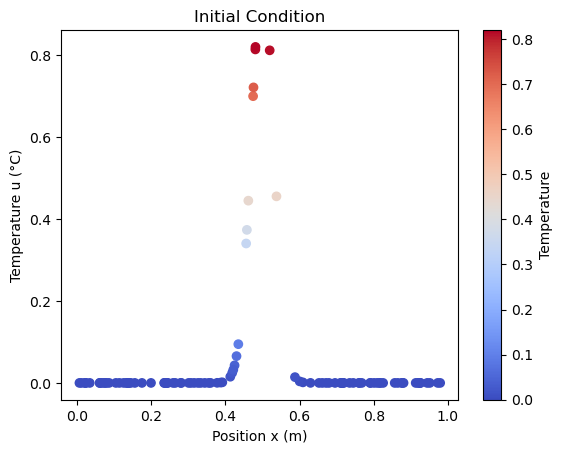

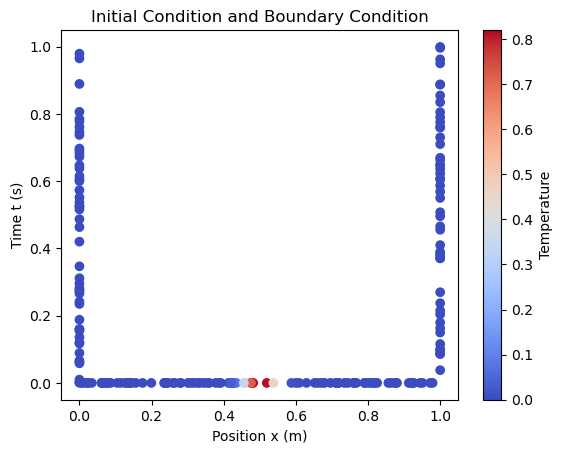

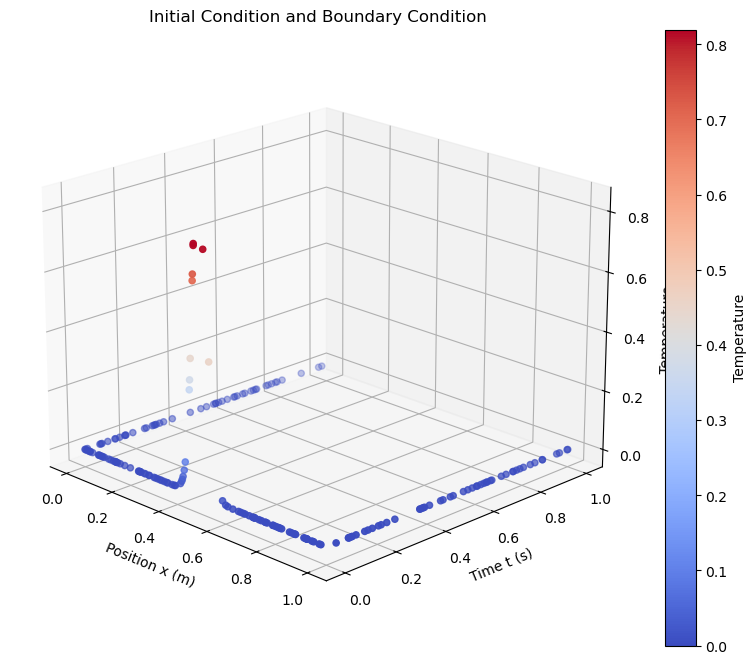

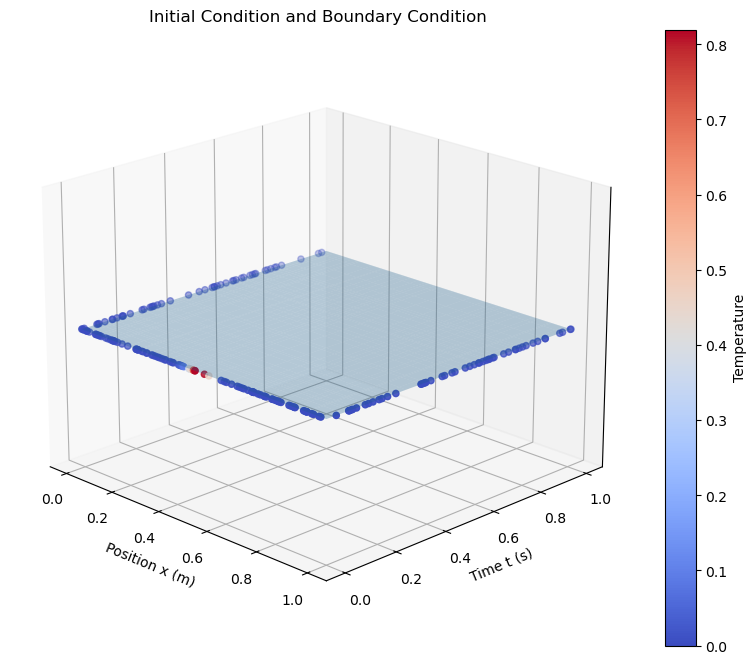

In [4]:
# Convert to numpy arrays
u_init_np = train_data['u_init'].detach().numpy()
x_init_np = train_data['x_init'].detach().numpy()
t_init_np = train_data['t_init'].detach().numpy()
x_boundary = train_data['x_boundary']
t_boundary = train_data['t_boundary']
u_boundary = train_data['u_boundary']
# Scatter plot of u_init_np vs x_init_np
# Set color of the points to blue-red gradient
plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
# set axis labels and title
plt.xlabel('Position x (m)')
plt.ylabel('Temperature u (°C)')
plt.title('Initial Condition')
plt.colorbar(label='Temperature')
plt.show()

# Plot u_init and u_boundary as scatter plot in one plot
# 2D plot, each point location is x ,t and the color is the temperature

# unite x_init_np and x_boundary in one array
x_ic_bc  = np.concatenate((x_init_np, x_boundary))
# unite t_init_np and t_boundary in one array
t_ic_bc = np.concatenate((t_init_np, t_boundary))
# unite u_init_np and u_boundary in one array
u_ic_bc = np.concatenate((u_init_np, u_boundary))

plt.scatter(x_ic_bc, t_ic_bc, c=u_ic_bc, cmap='coolwarm')
plt.xlabel('Position x (m)')
plt.ylabel('Time t (s)')
plt.title('Initial Condition and Boundary Condition')
plt.colorbar(label='Temperature')
plt.show()



# Modified plotting code
from mpl_toolkits.mplot3d import Axes3D

# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert tensors to numpy arrays with detach()
x_np = x_ic_bc
t_np = t_ic_bc
u_np = u_ic_bc

# Create the scatter plot
scatter = ax.scatter(x_np, t_np, u_np, c=u_np, cmap='coolwarm')

# Set labels
ax.set_xlabel('Position x (m)')
ax.set_ylabel('Time t (s)')
ax.set_zlabel('Temperature')

# Adjust the view angle to match the desired perspective
ax.view_init(elev=20, azim=-45)  # Adjust these angles to match the desired view

# Add colorbar
plt.colorbar(scatter, label='Temperature')

plt.title('Initial Condition and Boundary Condition')
plt.show()

# For a 2D tilted view (alternative approach)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot with zero height
x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
z_grid = np.zeros_like(x_grid)  # Create a flat surface

# Plot the surface
surf = ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.3)

# Add scatter points
scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')

# Set labels
ax.set_xlabel('Position x (m)')
ax.set_ylabel('Time t (s)')

# Remove z-axis
ax.set_zticks([])

# Adjust view angle for 2D-like perspective
ax.view_init(elev=20, azim=-45)

# Add colorbar
plt.colorbar(scatter, label='Temperature')

plt.title('Initial Condition and Boundary Condition')
plt.show()


### 4: Define PINN Neural Network Architecture

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # Building neural network layers
        ''' Choosing Tanh as activation function because of the smooth and bounded nature of the
             function, required for the derivatives computation '''
        self.model = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(), # Input layer: 2D (x,t) -> 64 neurons (Hidden layer 1)
            nn.Linear(64, 64), nn.Tanh(), # Hidden layer: 64 neurons (Hidden layer 2)
            nn.Linear(64, 1) # Output layer: 1D (u)
        )
    # Function to get the predicted temperature at a given spatial and temporal point
    def forward(self, x, t): 
        inputs = torch.cat([x, t], dim=1)  # Concatenate spatial and temporal inputs
        return self.model(inputs) # Pass spatial and temporal inputs through the network

model = PINN()

### 5: Define Loss Function
![](diff_eq.png)

In [6]:
# --- Loss functions with corrected normalization ---
def compute_pde_loss(model, x, t, system_params):
    """
    Compute normalized PDE residual loss for the 1D heat equation.
    for normalized x,t,u values in PDE loss, uses alpha_nd acounting for the units scaling
    """
    alpha = system_params['alpha']
    # nondimensionalized alpha:
    alpha_nd = alpha * T_max / (L**2) # Used for normalized values in PDE loss
    
    # network output
    u = model(x, t)
    
    # derivatives
    du_dt = torch.autograd.grad(u, t,grad_outputs=torch.ones_like(u), create_graph=True, retain_graph= True)[0]
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True, retain_graph= True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x,grad_outputs=torch.ones_like(du_dx),create_graph=True, retain_graph= True)[0]
                                 
    # raw residual
    residual = du_dt - alpha_nd * d2u_dx2
    # mean-squared residual loss
    loss = torch.mean(residual**2)
    return loss


def compute_data_loss(model, x, t, u_target):
    """
    Compute MSE data loss
    """
    u_pred = model(x, t)
    loss = torch.mean((u_pred - u_target)**2)
    return loss

def total_loss(model, system_params, train_data):
    """
    Combine PDE, initial-condition, and boundary-condition losses.
    """
    
    loss_pde = compute_pde_loss(model, train_data['x_domain'], train_data['t_domain'],system_params)
    loss_ic = compute_data_loss(model, train_data['x_init'], train_data['t_init'], train_data['u_init'])
    loss_bc = compute_data_loss(model, train_data['x_boundary'], train_data['t_boundary'], train_data['u_boundary'])
        
    combined = loss_pde + loss_ic + loss_bc

    return combined, loss_pde, loss_ic, loss_bc

total_loss(model, system_params, train_data)

(tensor(0.2334, grad_fn=<AddBackward0>),
 tensor(0.1882, grad_fn=<MeanBackward0>),
 tensor(0.0363, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>))

### 6: Training Loop

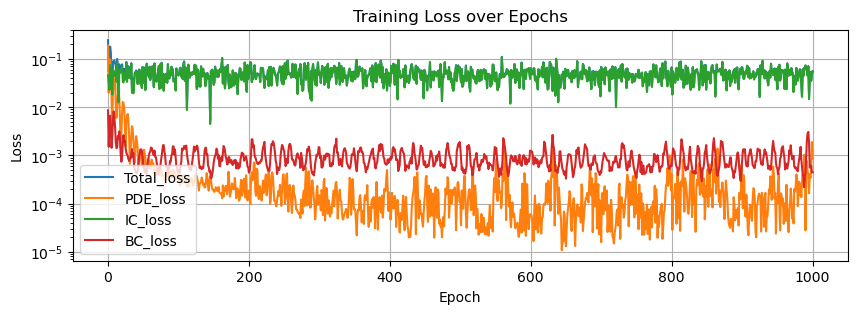

In [7]:
n_epochs = 1000
loss_history, loss_pde_history, loss_ic_history, loss_bc_history = [], [], [], [] # initialize lists to store loss values for plotting

# Define optimizer with learning rate for the model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001) 

for epoch in range(n_epochs + 1):
    optimizer.zero_grad()  # Reset gradients
    train_data = generate_training_data(system_params, n_domain = 100, n_boundary = 100)
    combined_loss,loss_pde, loss_ic, loss_bc = total_loss(model, system_params, train_data)  # Compute total loss
    combined_loss.backward(retain_graph=True)  # Compute gradients with retain_graph=True 
    optimizer.step()  # Update network parameters
    
    # Store losses for plotting
    loss_history.append(combined_loss.item())
    loss_pde_history.append(loss_pde.item())
    loss_ic_history.append(loss_ic.item())
    loss_bc_history.append(loss_bc.item())


# Plot the loss over epochs
plt.figure(figsize=(10, 3))
# plot loss_pde, loss_ic, loss_bc
plt.plot(loss_history, label='Total_loss')
plt.plot(loss_pde_history, label='PDE_loss')
plt.plot(loss_ic_history, label='IC_loss')
plt.plot(loss_bc_history, label='BC_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.yscale('log')  # Log scale often helps visualize loss decay better
plt.legend()
plt.show()


### 7: Visualization of Results

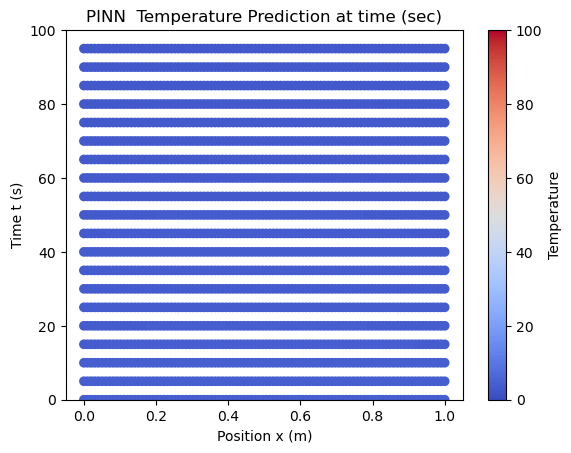

In [8]:
# Set numer of x points and time for plotting
n_plot = 100
sim_time_step = 5
T_final = 100

model.eval()  # Set model to evaluation mode

t=0
x_plot = []
t_plot = []
u_pred = []
while t < T_final:
    # Generate grid points for plotting
    x_real = torch.linspace(0, L, n_plot).reshape(-1, 1)
    t_real = torch.full_like(x_real, t)
    # Normalize x_real, t_real
    x_nd = x_real / L
    t_nd = t_real / T_max

    # Predict temperature distribution at final time
    with torch.no_grad():
        u_nd = model(x_nd, t_nd).numpy()
    # x plot and t plot to numpy
    x_ = x_real.numpy()
    t_ = t_real.numpy()
    x_plot.append(x_)
    t_plot.append(t_)
    u_pred.append(u_nd * U_max)
    t += sim_time_step




plt.scatter(x_plot, t_plot, c=u_pred, cmap='coolwarm')
plt.clim(0, 100)
plt.ylim(0, T_final)
plt.xlabel('Position x (m)')
plt.ylabel('Time t (s)')
plt.title(f'PINN  Temperature Prediction at time (sec)')
plt.colorbar(label='Temperature')
plt.show()